## Final Project Submission

Please fill out:
* Student name: Tia Plagata
* Student pace: full time
* Scheduled project review date/time: 10/19 10am EST
* Instructor name: Rafael Carrasco
* Blog post URL:


# Linear Regression

## Model Building & Choosing Features

**Assumptions**
1. Features are linearly related to target
2. Residuals are normally distributed
3. Residuals have homoscedasticity
4. Features do not have multicollinearity

In [161]:
# Import statements
import pandas as pd
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("ch:s=.25,rot=-.25")
import warnings
warnings.filterwarnings('ignore')

In [162]:
# Functions
def check_vif(df, target_col):
    """
    input a pandas dataframe, and name of the target column in ''
    checks vif score and returns vif score and whether or not there is multicollinearity of features with the target.
    """
    
    ols = build_sm_ols(df=df, target_col=target_col)
    vif = 1 / abs(1 - ols.rsquared)
    if vif <= 3:
        print('Good, low multi-collinearity. VIF:', vif)
    if vif <=5 and vif > 3: 
        print('Passable, but not great. VIF:', vif)
    if vif > 5:
        print('Not good. Strong multicollinearity. VIF:', vif)
        
def check_normality(data, alpha=0.05):
    """
    input array-like data (df column or series)
    returns p value for shapiro test and whether or not data is normally distributed
    """
    t, p = scs.shapiro(data)
    if p > alpha:
        return print('Data is normally distributed. P-Value:', p)
    else:
        return print('Data is NOT normally distributed. P-Value:', p)
    
def plot_corr(df):
    """
    input a pandas dataframe 
    returns a seaborn heatmap with correlations annotated.
    """
    corr = df.corr().abs()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr, annot=True, cmap=cmap)
    plt.show()
    
def build_sm_ols(df, target_col, add_constant=False, show_summary=False):
    """
    input a pandas dataframe and target column name in ''
    returns an ols model built with statsmodels
    if summary_on=True, returns ols summary
    if add_constant=True, adds constant to model
    """
    X = df.drop(columns=[target_col])
    if add_constant:
        X = sm.add_constant(X)
    y = df[target_col]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols

def normalize_feature(feature):
    """
    input a feature column name in as df['feature']
    returns series of normalized feature values
    """
    return (feature - feature.mean()) / feature.std()

def plot_qq(ols):
    """
    input statsmodel ols
    returns a qq plot of residuals against a normal distribution line to test for normality of residuals' distribution
    """
    residuals = ols.resid
    fig = plt.figure(figsize=(8,5))
    fig = sm.graphics.qqplot(residuals, dist=scs.norm, line='45', fit=True)
    fig.show()
    
def check_homoscedasticity(ols, alpha=0.05):
    """
    input a statsmodels ols model to run Breusch Pagan test for homoscedasticity.
    H0: residuals have homoscedasticity
    H1: residuals have heteroscedasticity
    returns the p value and whether or not the model residuals have homoscedasticity
    """
    residuals = ols.resid
    exog = ols.model.exog
    lm, lmp, f, fp = sms.het_breuschpagan(residuals, exog)
    if lmp < alpha:
        return print('Model residuals still has heteroscedasticity. Assumption not met. P-value:', lmp)
    else:
        return print('Model residuals have homoscedasticity. Assumption met. P-value:', lmp)

In [13]:
df = pd.read_csv('/Users/jordanrjohnson/DataScienceCourseMaterial/phase_2/dsc-phase-2-project-online/data/kc_house_data_cleaned.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [14]:
# Add our engineered features from the EDA
df['price_per_lotsqft'] = df['price'] / df['sqft_lot']

df['price_per_livingsqft'] = df['price'] / df['sqft_living']

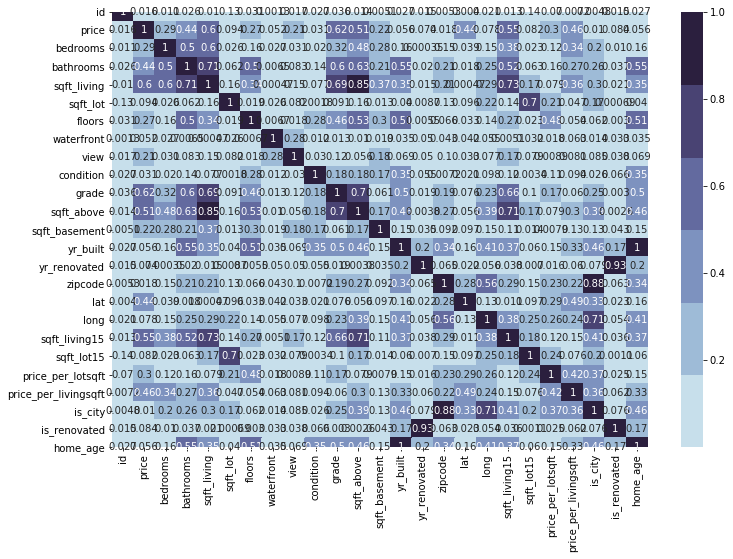

In [98]:
plot_corr(df)

**Iteration 1 (AKA Sanity Check)**
- Choose some features that don't look too multicollinear

In [152]:
# Create a model to test using the following features
features_to_use = ['bedrooms', 'sqft_living', 'condition', 'grade', 'price']
test_df = df[features_to_use]

ols1 = build_sm_ols(df=test_df, target_col='price', add_constant=False, show_summary=True)


                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          5.361e+04
Date:                Wed, 07 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:42:38   Log-Likelihood:                     -2.6731e+05
No. Observations:               20057   AIC:                                  5.346e+05
Df Residuals:                   20053   BIC:                                  5.347e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [20]:
# Check for multicollinearity in model
check_vif(test_df, target_col='price')

Not good. Strong multicollinearity. VIF: 11.693143224799533


In [21]:
# Check for heteroscedasticity in model
check_homoscedasticity(ols1)

Model residuals still has heteroscedasticity. Assumption not met. P-value: 0.0


**Iteration 2**
- Build a feature that makes better sense of zipcodes
    - is_city is a categorical feature that tells if a home is located in the city/Seattle-proper (1) or in the suburbs (0)
- Log transform and normalize all continuous features
- Use only continuous features in this model to see their effects

In [37]:
# Research city zipcodes to create feature: suburbs 0 or city 1
df.zipcode.sort_values().unique()

suburbs = [98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
           98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
           98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
           98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
           98072, 98074, 98075, 98077, 98092, 98148, 98155, 98166, 98168,
           98188, 98198]
city = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109,
        98112, 98115, 98116, 98117, 98118, 98119, 98121, 98122, 98125,
        98126, 98133, 98134, 98136, 98144, 98146, 98154, 98164, 98174,
        98177, 98178, 98195, 98199]

df['is_city'] = df['zipcode'].apply(lambda x: 0 if x < 98100 and x != 98148 and x != 98155
                                    and x != 98166 and x != 98168 and x != 98188 and x != 98198
                                    else 1)

df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_lotsqft,price_per_livingsqft,is_city
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,39.274336,188.050847,1
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,74.288870,209.338521,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,1933,0.0,98028,47.7379,-122.233,2720,8062,18.000000,233.766234,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,120.800000,308.163265,1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,63.118812,303.571429,0
5,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,1995,0.0,98003,47.3097,-122.327,2238,6819,37.762135,150.145773,0
6,2414600126,2015-04-15,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,1960,0.0,98146,47.5123,-122.337,1780,8113,30.722892,128.932584,1
7,3793500160,2015-03-12,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,2003,0.0,98038,47.3684,-122.031,2390,7570,49.237805,170.899471,0
8,1736800520,2015-04-03,662500.0,3,2.50,3560,9796,1.0,0.0,0.0,...,1965,0.0,98007,47.6007,-122.145,2210,8925,67.629645,186.095506,0
9,9212900260,2014-05-27,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,...,1942,0.0,98115,47.6900,-122.292,1330,6000,78.000000,403.448276,1


In [49]:
continuous = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'price_per_livingsqft']
df_cont = df[continuous]
df_cont.head()

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,price_per_livingsqft
0,221900.0,1180,5650,1340,5650,188.050847
1,538000.0,2570,7242,1690,7639,209.338521
2,180000.0,770,10000,2720,8062,233.766234
3,604000.0,1960,5000,1360,5000,308.163265
4,510000.0,1680,8080,1800,7503,303.571429


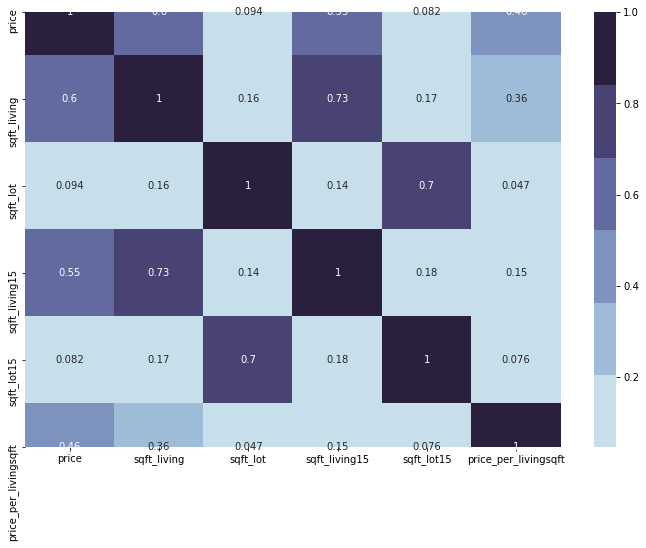

In [44]:
plot_corr(df_cont)

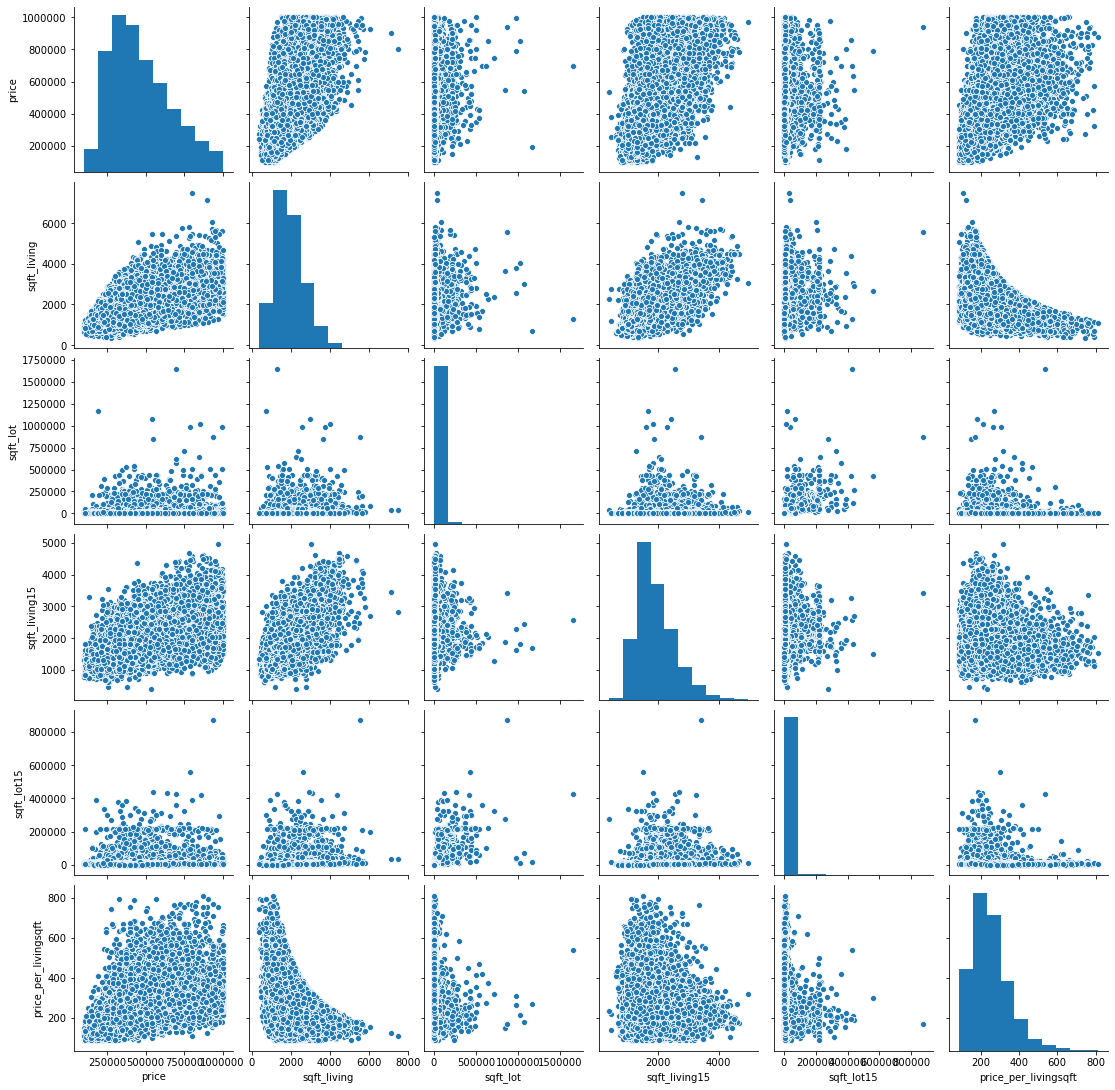

In [150]:
# Look at distributions of features
sns.pairplot(df_cont)
plt.show()

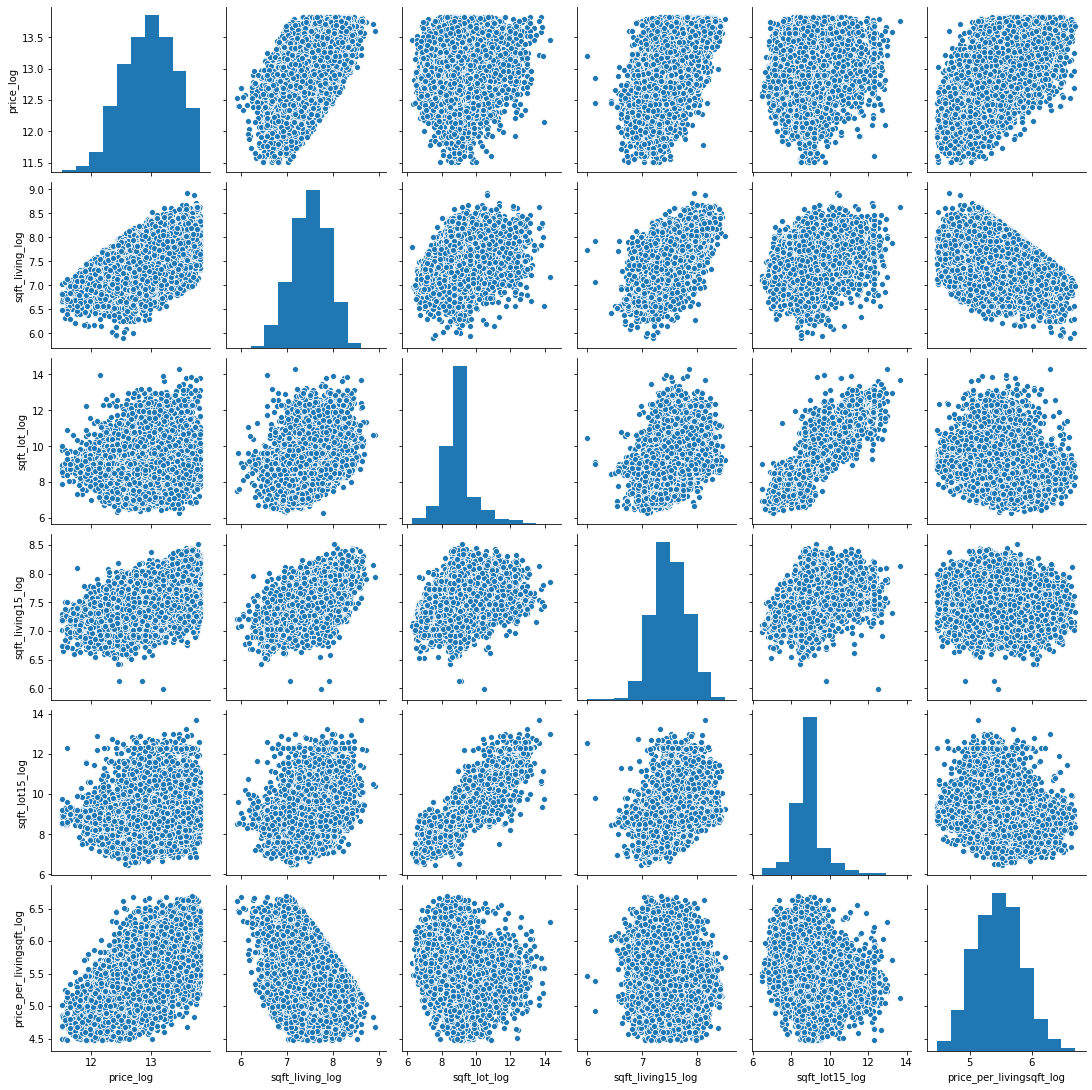

In [50]:
# Let's log transform all continuous variables and see their distributions again
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

sns.pairplot(df_log)
plt.show()

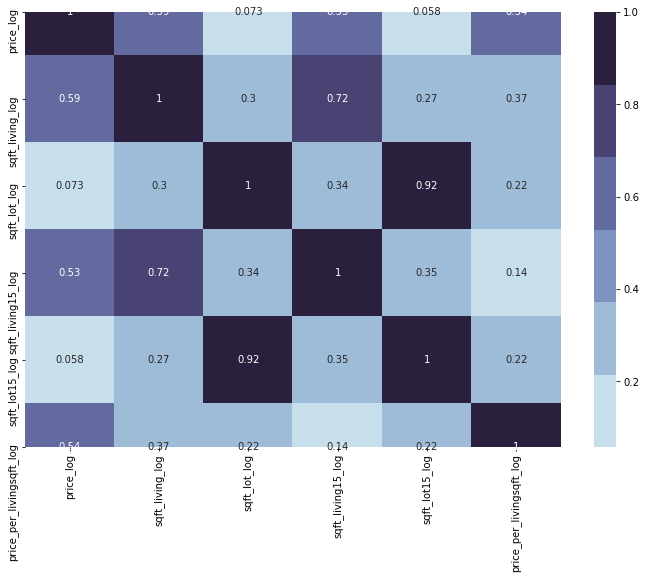

In [51]:
# It is clear that lot sqft is not very correlated to our target.
# We should probably also drop sqft_living15 since it's so correlated to sqft_living
plot_corr(df_log)

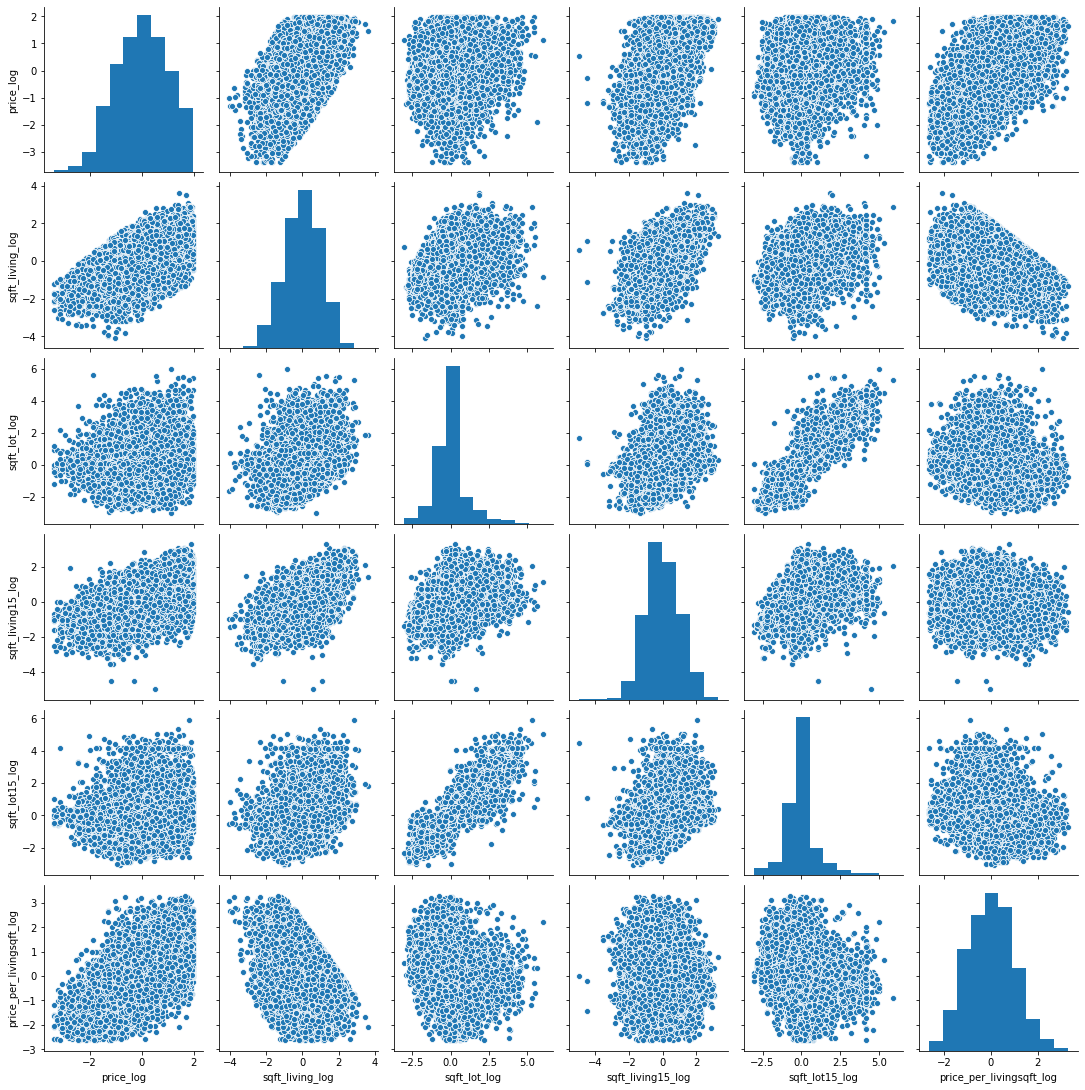

In [53]:
# Before we drop those, let's also normalize these features and check them out again
df_log_normal = df_log.apply(normalize_feature)

sns.pairplot(df_log_normal)
plt.show()

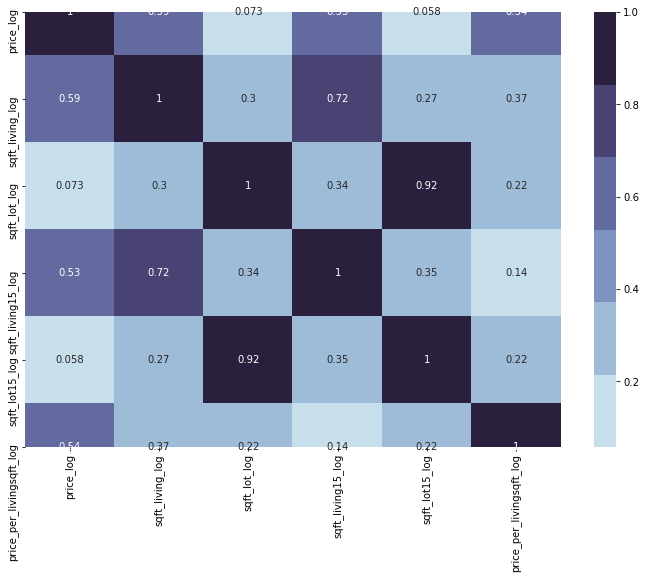

In [54]:
plot_corr(df_log_normal)

In [55]:
# Let's see if this improved our original model 
# (modeling only off continuous features and getting rid of the lot sq ft, sqft_lot15 and sqft_living15
df_log_normal = df_log_normal.drop(columns=['sqft_lot15_log', 'sqft_lot_log', 'sqft_living15_log'])
df_log_normal.head()

,price_log,sqft_living_log,price_per_livingsqft_log
0,-1.523127,-1.101958,-0.601883
1,0.528893,0.886085,-0.316167
2,-2.008008,-2.192224,-0.022115
3,0.797008,0.194039,0.714043
4,0.405054,-0.199668,0.674045


In [80]:
# Build 2nd iteration, adding a constant this time
ols2 = build_sm_ols(df_log_normal, 'price_log', add_constant=True, show_summary=True)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.655e+33
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        13:21:55   Log-Likelihood:             6.4622e+05
No. Observations:               20057   AIC:                        -1.292e+06
Df Residuals:                   20054   BIC:                        -1.292e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [81]:
# Check assumptions
check_vif(df_log_normal, 'price_log')
check_normality(ols2.resid)
check_homoscedasticity(ols2)

Not good. Strong multicollinearity. VIF: inf
Data is NOT normally distributed. P-Value: 5.3682076561756276e-09
Model residuals still has heteroscedasticity. Assumption not met. P-value: 3.2915644252508904e-17


**Iteration 3**
- Mess with categorical features
- Engineer some new features out of them
    - is_renovated tells if the home has been renovated between 1960 and 2000 (1), if it was renovated after 2000 (2) or if it was not renovated at all/renovated before 1960 (0)
    - home_age calculates how old the home is in years assuming it is the year 2015 (when most of these homes were sold)
- Use those features and the continuous ones to build a 3rd model

In [61]:
# Let's work with our categorical variables now.
print(df.columns)
categoricals = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition',
                'grade', 'yr_built', 'yr_renovated', 'is_city']

df_cat = df[categoricals]
df_cat.head()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_per_lotsqft',
       'price_per_livingsqft', 'is_city'],
      dtype='object')


,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,is_city
0,3,1.00,1.0,0.0,3,7,1955,0.0,1
1,3,2.25,2.0,0.0,3,7,1951,1991.0,1
2,2,1.00,1.0,0.0,3,6,1933,0.0,0
3,4,3.00,1.0,0.0,5,7,1965,0.0,1
4,3,2.00,1.0,0.0,3,8,1987,0.0,0


In [68]:
# Let's create some features out of these to make them more useful
df_cat.yr_renovated.sort_values().unique()

array([   0., 1934., 1940., 1944., 1945., 1946., 1948., 1950., 1951.,
       1953., 1954., 1955., 1956., 1957., 1958., 1959., 1960., 1962.,
       1963., 1964., 1965., 1967., 1968., 1969., 1970., 1971., 1972.,
       1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981.,
       1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990.,
       1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999.,
       2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
       2009., 2010., 2011., 2012., 2013., 2014., 2015.])

In [69]:
# Feature for is_renovated 0 being not renovated, or renovated so long ago that it is not actually relevant anymore
#  1 if renovated before 2000 and 2 if renovated after 2000
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 0 if x <= 1960 else 1 if x <2000 and x > 1960 else 2)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_lotsqft,price_per_livingsqft,is_city,is_renovated
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,98178,47.5112,-122.257,1340,5650,39.274336,188.050847,1,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1991.0,98125,47.7210,-122.319,1690,7639,74.288870,209.338521,1,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,98028,47.7379,-122.233,2720,8062,18.000000,233.766234,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0.0,98136,47.5208,-122.393,1360,5000,120.800000,308.163265,1,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,98074,47.6168,-122.045,1800,7503,63.118812,303.571429,0,0


In [70]:
# Make feature for home age assuming we are in 2015 (the year of most sold dates)
df['home_age'] = df['yr_built'].apply(lambda x: 2015 - x)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_lotsqft,price_per_livingsqft,is_city,is_renovated,home_age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,98178,47.5112,-122.257,1340,5650,39.274336,188.050847,1,0,60
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,74.288870,209.338521,1,1,64
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,18.000000,233.766234,0,0,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,120.800000,308.163265,1,0,50
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,63.118812,303.571429,0,0,28


In [99]:
# Now we can play with these new categorical features
categoricals = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
                'condition', 'grade', 'is_city', 'is_renovated', 'home_age']

df_cat = df[categoricals]
df_cat.head()

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,is_city,is_renovated,home_age
0,3,1.00,1.0,0.0,0.0,3,7,1,0,60
1,3,2.25,2.0,0.0,0.0,3,7,1,1,64
2,2,1.00,1.0,0.0,0.0,3,6,0,0,82
3,4,3.00,1.0,0.0,0.0,5,7,1,0,50
4,3,2.00,1.0,0.0,0.0,3,8,0,0,28


In [100]:
df_preprocessed = pd.concat([df_log_normal, df_cat], axis=1)
df_preprocessed.head()

,price_log,sqft_living_log,price_per_livingsqft_log,bedrooms,bathrooms,floors,waterfront,view,condition,grade,is_city,is_renovated,home_age
0,-1.523127,-1.101958,-0.601883,3,1.00,1.0,0.0,0.0,3,7,1,0,60
1,0.528893,0.886085,-0.316167,3,2.25,2.0,0.0,0.0,3,7,1,1,64
2,-2.008008,-2.192224,-0.022115,2,1.00,1.0,0.0,0.0,3,6,0,0,82
3,0.797008,0.194039,0.714043,4,3.00,1.0,0.0,0.0,5,7,1,0,50
4,0.405054,-0.199668,0.674045,3,2.00,1.0,0.0,0.0,3,8,0,0,28


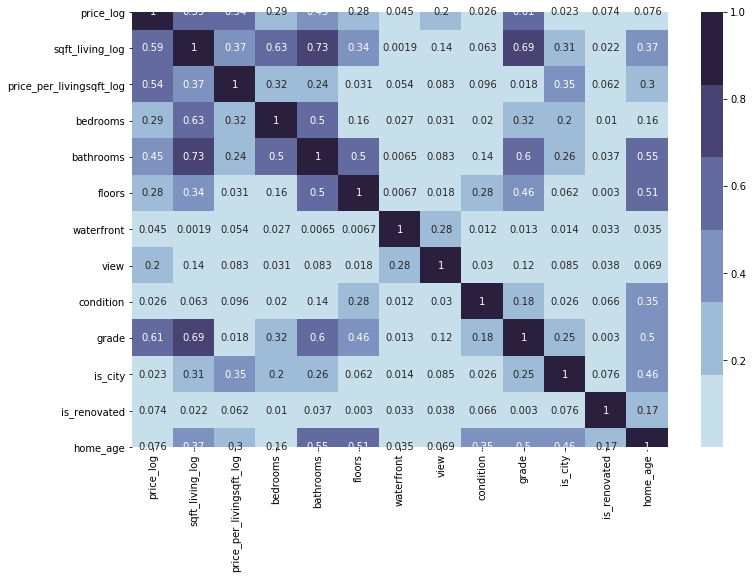

In [101]:
plot_corr(df_preprocessed)

In [102]:
# Let's try a 3rd iteration using our transformed features and new categorical features
ols3 = build_sm_ols(df_preprocessed, 'price_log', add_constant=True, show_summary=True)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.530e+31
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:30:16   Log-Likelihood:             6.1722e+05
No. Observations:               20057   AIC:                        -1.234e+06
Df Residuals:                   20044   BIC:                        -1.234e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [103]:
# Check assumptions 
check_vif(df_preprocessed, 'price_log')
check_normality(ols3.resid)
check_homoscedasticity(ols3)

Not good. Strong multicollinearity. VIF: inf
Data is NOT normally distributed. P-Value: 4.860339214429743e-11
Model residuals still has heteroscedasticity. Assumption not met. P-value: 0.0


**Iteration 4**
- Start to eliminate features and see their effect on multicollinearity
- Specifically eliminate sqft_living since it is correlated with almost everything else, and use price per sqft living instead (a feature engineered during EDA)

In [104]:
# Iteration 4: Let's get rid of things one at a time and see if that helps
df_trial4 = df_preprocessed.drop(columns=['sqft_living_log'])
ols4 = build_sm_ols(df_trial4, 'price_log', add_constant=True, show_summary=True)
check_vif(df_trial4, 'price_log')
check_normality(ols4.resid)
check_homoscedasticity(ols4)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     7824.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:30:44   Log-Likelihood:                -11746.
No. Observations:               20057   AIC:                         2.352e+04
Df Residuals:                   20045   BIC:                         2.361e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<Figure size 576x360 with 0 Axes>

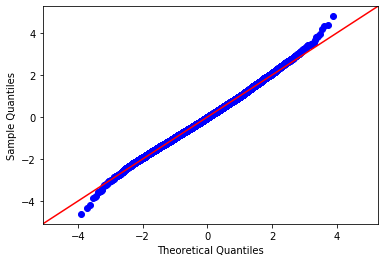

In [105]:
plot_qq(ols4)

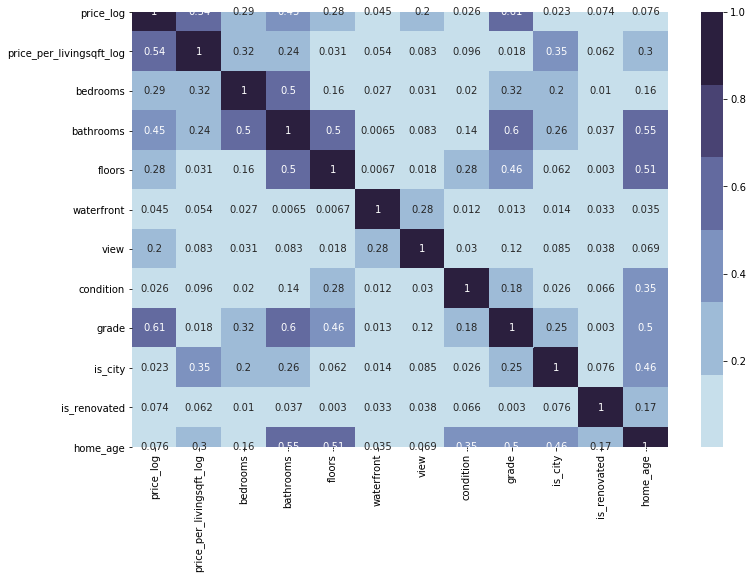

In [106]:
plot_corr(df_trial4)

**Iteration 5**
- Transform the bathroom feature 
    - bath-bed is a feature that indicated the number of excess bathrooms a home has (i.e. if there is one bathroom per bedroom, how many bathrooms are left in the house?)

In [153]:
df_preprocessed['bath-bed'] = df_preprocessed['bedrooms'] - df_preprocessed['bathrooms']

In [113]:
df_trial5 = df_preprocessed.drop(columns=['sqft_living_log', 'bathrooms'])
ols5 = build_sm_ols(df_trial5, 'price_log', add_constant=True, show_summary=True)
check_vif(df_trial5, 'price_log')
check_normality(ols5.resid)
check_homoscedasticity(ols5)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     7824.
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:51:45   Log-Likelihood:                -11746.
No. Observations:               20057   AIC:                         2.352e+04
Df Residuals:                   20045   BIC:                         2.361e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**Iteration 6**
- Drop the features with p-values < 0.05 alpha, AKA features that are not significant to our model 
    - includes: is_renovated, floors, and waterfront
- Also drop bathrooms since we added our new bathroom feature during the last iteration

In [124]:
# Let's drop the columns without significant p-values
df_trial6 = df_preprocessed.drop(columns=['sqft_living_log', 'bathrooms', 'is_renovated', 'floors', 'waterfront'])
ols6 = build_sm_ols(df_trial6, 'price_log', add_constant=True, show_summary=True)
check_vif(df_trial6, 'price_log')
check_normality(ols6.resid)
check_homoscedasticity(ols6)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 1.076e+04
Date:                Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:28:43   Log-Likelihood:                -11749.
No. Observations:               20057   AIC:                         2.352e+04
Df Residuals:                   20048   BIC:                         2.359e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

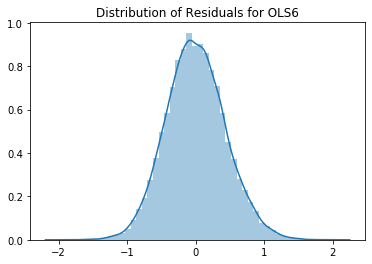

In [125]:
# Check distribution of residuals on a graph
sns.distplot(ols6.resid)
plt.title('Distribution of Residuals for OLS6')
plt.show()

<Figure size 576x360 with 0 Axes>

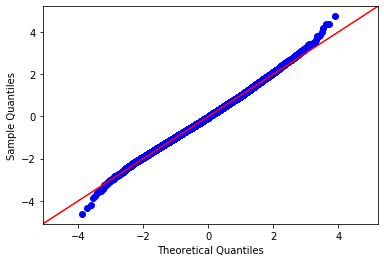

In [126]:
plot_qq(ols6)
# Looks normal, but with some kurtosis

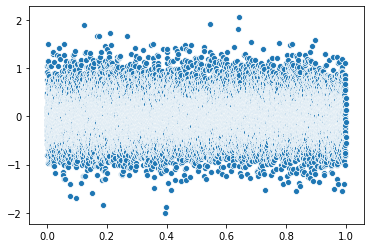

In [128]:
# Plot residuals 
residuals = ols6.resid
xaxis = np.linspace(0, 1, len(residuals))
sns.scatterplot(xaxis, residuals)
plt.show()
# Looks pretty homoscedasticitous 

In [133]:
# Let's check for normal distribution for a random sample of our data since the number of observations in this data
# set is so high (20,000+)

check_normality(np.random.choice(ols6.resid, size=500))

Data is normally distributed. P-Value: 0.6152844429016113


## Model Validation

Happy with this model (OLS6) so let's move it over to sklearn to validate the model and check the mean-squared error

In [138]:
# Final features based off OLS6
features_final = ['price_per_livingsqft_log', 'bedrooms', 'view',
       'condition', 'grade', 'is_city', 'home_age', 'bath-bed']
target = ['price_log']

In [139]:
linreg = LinearRegression()
X = df_preprocessed[features_final]
y = df_preprocessed[target]

In [141]:
# Do a train-test split using a 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=33)
print(len(X_train), len(X_test))

14039 6018


In [170]:
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Look at residuals and calculate MSE
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train mse:', train_mse)
print('Test mse:', test_mse)
# They're close together! Yay! (Indicates that we are NOT overfitting)

Train mse: 0.18905611978063014
Test mse: 0.18874960388004056


In [147]:
# K-Fold Cross-Validation with 20 folds
mse = make_scorer(mean_squared_error)
cv_20_results = cross_val_score(linreg, X, y, cv=20, scoring=mse)
cv_20_results.mean()
# Also close to our train-test split mse!

0.1896093517379841

In [160]:
# Check R2 score for the train-test split
print('Train Data', r2_score(y_train, linreg.predict(X_train)))
print('Test Data', r2_score(y_test, linreg.predict(X_test)))

print('We can predict the home price with roughly 80% accuracy.')

Train Data 0.8119429014430364
Test Data 0.8088393068233344
We can predict the home price with roughly 80% accuracy.


In [172]:
# Transform back to regular $USD price (not log price)
train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(y_hat_train))
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(y_hat_test))
print('Train mse non-log:', train_mse)
print('Test mse non-log:', test_mse)

Train mse non-log: 0.18905611978063014
Test mse non-log: 0.18874960388004056


## Choosing which features are most important

- Use feature ranking/recursive feature elimination to see which are the 3 most important features
    - use these features to discuss in the presentation

In [163]:
selector = RFE(linreg, n_features_to_select=3)
selector = selector.fit(X, y)

selector.support_

array([ True,  True, False, False,  True, False, False, False])

In [164]:
features_final

['price_per_livingsqft_log',
 'bedrooms',
 'view',
 'condition',
 'grade',
 'is_city',
 'home_age',
 'bath-bed']

In [166]:
linreg.coef_

array([[ 0.6568185 ,  0.69450585,  0.08639293,  0.03592341,  0.4154199 ,
        -0.11582602,  0.0053202 , -0.440505  ]])

**Therefore, the top 3 most important features are:**

- price_per_livingsqft_log
- bedrooms
- condition

**Coefficients for these features:**
- price_per_livingsqft_log : 0.6568
- bedrooms: 0.6945
- condition: 0.4154


## Model Conclusion

This linear regression model is able to predict the housing price in King County with roughly 80% accuracy. The average of mean squared errors using a k-fold cross validation with 20 folds is 0.19, meaning the average distance between the model prediction and the data is very small. When performing a train-test split with a 70:30 ratio, the mean squared errors are 0.1890 and 0.1887 respectively. Since they are very close, we can assume that the model is not overfit. 

**Meeting Assumptions**

This linear regression model meets the following assumptions:
- The features are linearly related to the target.
    - Features whose coefficients had a p-value greater than 0.05 (our alpha) were removed from the model.
- There is little to no multicollinearity in this model. 
    - VIF score for this model was less than 3 (2.5) indicating low multicollinearity of features. 
    - Condition number was 612, which is another indication of low multicollinearity of features.
- The distribution of model residuals are normally distributed.
    - When plotting the distribution of residuals, the curve looks pretty normal, but has some kurtosis.
    - The model residuals did not pass the Shapiro-Wilkes Test for normality on their own due to a very large number of data points (over 20,000)
    - However, a random sample of 500 residuals DOES pass the Shapiro-Wilkes test for normality.
- The model residuals have some homoscedasticity.
    - When plotting a scatterplot of model residuals, there seems to be homoscedasticity (even scatter).
    - However, the residuals did not pass the Breusch-Pagan Test for homoscedasticity, meaning that this assumption is not totally met. The failure to pass this test could also be due to the very large number of data points. 
    
**Features Used, and their coefficients:**
- 'price_per_livingsqft_log': 0.6568
- 'bedrooms': 0.6945
- 'view': 0.0864
- 'condition': 0.0359
- 'grade': 0.4154
- 'is_city': -0.1158
- 'home_age': 0.0053
- 'bath-bed': -0.4405
    
In conclusion, this model functions fairly well, but could benefit from more tinkering to increase the r2 score. 